# Shapley values

In this notebook, the example of the Salary prediction, we've used to detect bias, is used.

A random forest is trained on a reweighed dataset.

The first part of this notbook contains the elements to prepare the data and train the model.

As from section 5, the interpretation of the model is studied by analysing shapley values.

In [4]:
# The dataset we'll use in this notebook originates from "kaggle".

# !pip install -qU kagglehub

In [5]:
# Import the python packages that will be used throughout the notebook.

import os
import pandas as pd
import numpy as np
import seaborn as sns 
import joblib
import matplotlib.pyplot as plt 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools
from IPython.display import Markdown, display

In [6]:
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,log_loss

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
import itertools

pd.options.display.float_format = '{:.2f}'.format

import warnings                   # to deal with warnings
warnings.filterwarnings('ignore')

### 1. Download, read, explore and preprocess the data

#### 1.1 Download
Download the salary-prediction-classification dataset from "kaggle".

In [7]:
import kagglehub

# Download latest version
# ref. https://www.kaggle.com/datasets/ayessa/salary-prediction-classification/data
path = kagglehub.dataset_download("ayessa/salary-prediction-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/vpes623/.cache/kagglehub/datasets/ayessa/salary-prediction-classification/versions/1


#### 1.2 Read the data

In [8]:
df = pd.read_csv(os.path.join(path, 'salary.csv'))

#### 1.3 Explore and preprocess the data

In [9]:
df.shape

(32561, 15)

In [10]:
for col in df.columns:
    print(col)

age
workclass
fnlwgt
education
education-num
marital-status
occupation
relationship
race
sex
capital-gain
capital-loss
hours-per-week
native-country
salary


In [11]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
# Check for duplicates

In [13]:
duplicates = df.duplicated().sum()
print(duplicates)

24


In [14]:
# Check for missing values
isna = df.isna().sum()
print(isna)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64


In [15]:
# Let's get rid of duplicate entries

df.drop_duplicates(keep='first',inplace=True)

In [16]:
# Again check the dataset shape, after removing the duplicate entries

print(f'Number of records (rows) in the dataset are: {df.shape[0]}')
print(f'Number of features (columns) in the dataset are: {df.shape[1]}')
print(f'Number of duplicate entries in the dataset are: {df.duplicated().sum()}')

Number of records (rows) in the dataset are: 32537
Number of features (columns) in the dataset are: 15
Number of duplicate entries in the dataset are: 0


In [17]:
# Let's check the labels in the categorical features

for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].unique())


workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

marital-status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']

relationship
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

race
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']

sex
[' Male' ' Female']

native-country
[' United-States' ' Cuba' ' Jamaica' ' 

Some Observations

It is observed that extra spaces are appearing everywhere in the dataset (you can see an extra space before first letter of each label in the above output)
It is also observed that ' ?' symbol is appearing in workclass, occupation, and native-country features.
Let's replace the symbol with 'nan' to add appropriate values in later steps.

In [18]:
# First we remove all the extra spaces across the dataset

# df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

## Now let's replace the '?' symbol with 'nan' throughout the dataset

df_filled = df.replace('?', np.nan, inplace=False)

# Check the dataset features with null values ('nan')

numer_of_na_s = pd.isna(df_filled).sum()[pd.isna(df_filled).sum() > 0]
print(f"numer_of_na_s: \n {numer_of_na_s}")

numer_of_na_s: 
 workclass         1836
occupation        1843
native-country     582
dtype: int64


Observations

Upon checking the dataset, it is understood that occupation is missing in a record, wherever the workclass is missing for that record.

The missing values reported are all missing values for categorical variables. Therefore it is good to create a particular label for those missing values, like the ' ?' from before, or for example "Unknown Other" or "missing".

In [19]:
df = df.replace('?', 'missing', inplace=False)

In [20]:
print(df.shape)

(32537, 15)


In [21]:
# let's rename (segregate) some labels in select features to 
   ## 1. rectify erros 
   ## 2. to consolidate
   ## 3. to shorten them for visualisation purpose

df = df.replace({'workclass': {'State-gov': 'Govt.', 'Self-emp-not-inc': 'self_emp', 'Federal-gov': 'Govt.', 'Local-gov': 'Govt.', 'Self-emp-inc':'self_emp', 'Without-pay': 'UnknCl', 'Never-worked': 'UnknCl'}}, inplace=False)
df = df.replace({'marital-status': {'Married-civ-spouse': 'Married', 'Divorced': 'DASW', 'Married-spouse-absent': 'DASW', 'Separated': 'DASW', 'Married-AF-spouse':'Married', 'Widowed': 'DASW'}}, inplace=False)
df = df.replace({'occupation': {'Adm-clerical': 'Adminstration', 'Exec-managerial': 'Executive', 'Handlers-cleaners': 'Handlers', 'Prof-specialty': 'Profesionals', 'Other-service' : 'UnknOc', 'Craft-repair' : 'Repairing', 'Farming-fishing' : 'Farming', 'Transport-moving':'Transportation', 'Machine-op-inspct': 'MachineOp', 'Protective-serv' : 'ProtectiveServ', 'Priv-house-serv': 'HouseServ'}}, inplace=False)
df = df.replace({'native-country': {'United-States': 'USA', 'South': 'SouthKorea', 'Puerto-Rico': 'PuertoRico', 'Dominican-Republic': 'DominicRep', 'Outlying-US(Guam-USVI-etc)':'OutlyingUSA', 'Trinadad&Tobago': 'Tri&Tob', 'Holand-Netherlands': 'Netherlands', 'Hong' : 'HongKong'}}, inplace=False)
df = df.replace({'race': {'Asian-Pac-Islander': 'APAC', 'Amer-Indian-Eskimo': 'NatAm'}}, inplace=False)
## df.replace({'salary': {'<=50K': 0, '>50K': 1}}, inplace=True)

## Checking whether the modification has been made or not

for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].unique())
        


workclass
['Govt.' 'self_emp' 'Private' 'missing' 'UnknCl']

education
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

marital-status
['Never-married' 'Married' 'DASW']

occupation
['Adminstration' 'Executive' 'Handlers' 'Profesionals' 'UnknOc' 'Sales'
 'Repairing' 'Transportation' 'Farming' 'MachineOp' 'Tech-support'
 'missing' 'ProtectiveServ' 'Armed-Forces' 'HouseServ']

relationship
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

race
['White' 'Black' 'APAC' 'NatAm' 'Other']

sex
['Male' 'Female']

native-country
['USA' 'Cuba' 'Jamaica' 'India' 'missing' 'Mexico' 'SouthKorea'
 'PuertoRico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran' 'Philippines'
 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador' 'Laos'
 'Taiwan' 'Haiti' 'Portugal' 'DominicRep' 'El-Salvador' 'France'
 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru' 'O

In [22]:
# Since many native countries are there, we will check the records to understand the trend 
# and make modification if needed

df['native-country'].value_counts()

native-country
USA            29153
Mexico           639
missing          582
Philippines      198
Germany          137
Canada           121
PuertoRico       114
El-Salvador      106
India            100
Cuba              95
England           90
Jamaica           81
SouthKorea        80
China             75
Italy             73
DominicRep        70
Vietnam           67
Guatemala         62
Japan             62
Poland            60
Columbia          59
Taiwan            51
Haiti             44
Iran              43
Portugal          37
Nicaragua         34
Peru              31
France            29
Greece            29
Ecuador           28
Ireland           24
HongKong          20
Tri&Tob           19
Cambodia          19
Thailand          18
Laos              18
Yugoslavia        16
OutlyingUSA       14
Honduras          13
Hungary           13
Scotland          12
Netherlands        1
Name: count, dtype: int64

It appears that USA is the top native country, and has highest number of records, somewhere around 90% of total records.

In [23]:
# We'll make two separate dataframes for native country feature, for use in visualisations.

USA = df[df['native-country'] == 'USA']
NonUSA = df[df['native-country'] != 'USA']

print('USA', USA.shape)
print('NonUSA', NonUSA.shape)

USA (29153, 15)
NonUSA (3384, 15)


In [24]:
# Before proceeding to EDA, let's have a glance at the dataframe using -
# info() and describe() functions

print(df.info())
print(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  salary          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB
None
                  count unique           top   freq      mean       std  \
age            325

## Start the model building

In [25]:
## Okay, we will stop our eda there, and start with Model Building & Machine Learning

## Grouping the features into numerical & categorical 

num_df = df[['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']] 
cat_df = df[['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country', 'salary']]

In [26]:
for col in cat_df.columns:
    print(f"col: {col}, n_unique: {cat_df[col].nunique()}")

col: workclass, n_unique: 5
col: education, n_unique: 16
col: education-num, n_unique: 16
col: marital-status, n_unique: 3
col: occupation, n_unique: 15
col: relationship, n_unique: 6
col: race, n_unique: 5
col: sex, n_unique: 2
col: native-country, n_unique: 42
col: salary, n_unique: 2


In [27]:
print(cat_df[['education', 'education-num']].head())

   education  education-num
0  Bachelors             13
1  Bachelors             13
2    HS-grad              9
3       11th              7
4  Bachelors             13


In [28]:
data_encoded = df.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in cat_df.columns.to_list():
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])

    categorical_names[feature] = le.classes_
    encoders[feature] = le


for k, v in categorical_names.items():
    print(f"k: {k}, v: {v}")
"""
for k, v in encoders.items():
    print(f"k: {k}, v: {v}")
"""

k: workclass, v: ['Govt.' 'Private' 'UnknCl' 'missing' 'self_emp']
k: education, v: ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']
k: education-num, v: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
k: marital-status, v: ['DASW' 'Married' 'Never-married']
k: occupation, v: ['Adminstration' 'Armed-Forces' 'Executive' 'Farming' 'Handlers'
 'HouseServ' 'MachineOp' 'Profesionals' 'ProtectiveServ' 'Repairing'
 'Sales' 'Tech-support' 'Transportation' 'UnknOc' 'missing']
k: relationship, v: ['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'Wife']
k: race, v: ['APAC' 'Black' 'NatAm' 'Other' 'White']
k: sex, v: ['Female' 'Male']
k: native-country, v: ['Cambodia' 'Canada' 'China' 'Columbia' 'Cuba' 'DominicRep' 'Ecuador'
 'El-Salvador' 'England' 'France' 'Germany' 'Greece' 'Guatemala' 'Haiti'
 'Honduras' 'HongKong' 'Hungary' 'India' 'Iran' 'Ireland' 'It

'\nfor k, v in encoders.items():\n    print(f"k: {k}, v: {v}")\n'

In [29]:
print(df.shape)
print(data_encoded.shape)

print(data_encoded.head())

(32537, 15)
(32537, 15)
   age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          0   77516          9             12               2   
1   50          4   83311          9             12               1   
2   38          1  215646         11              8               0   
3   53          1  234721          1              6               1   
4   28          1  338409          9             12               1   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           0             1     4    1          2174             0   
1           2             0     4    1             0             0   
2           4             1     4    1             0             0   
3           4             0     1    1             0             0   
4           7             5     1    0             0             0   

   hours-per-week  native-country  salary  
0              40              38       0  
1              13              38       

In [30]:
def decode_dataset(data, encoders, categorical_features):
    df = data.copy()

    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [31]:
numerical_features = num_df.columns.to_list()
categorical_features = cat_df.columns.to_list()

result = decode_dataset(data_encoded, encoders, categorical_features)

print("## RESULT : ORIGINAL ##")
print(result.head())

print("## DATA ENCODED : READY FOR THE MODEL ##")
print(data_encoded.head())

## RESULT : ORIGINAL ##
   age workclass  fnlwgt  education  education-num marital-status  \
0   39     Govt.   77516  Bachelors             13  Never-married   
1   50  self_emp   83311  Bachelors             13        Married   
2   38   Private  215646    HS-grad              9           DASW   
3   53   Private  234721       11th              7        Married   
4   28   Private  338409  Bachelors             13        Married   

      occupation   relationship   race     sex  capital-gain  capital-loss  \
0  Adminstration  Not-in-family  White    Male          2174             0   
1      Executive        Husband  White    Male             0             0   
2       Handlers  Not-in-family  White    Male             0             0   
3       Handlers        Husband  Black    Male             0             0   
4   Profesionals           Wife  Black  Female             0             0   

   hours-per-week native-country salary  
0              40            USA  <=50K  
1       

In [32]:
## Now we check the corrleation of features with the target variable (salary)
main_df = data_encoded.copy()
corr_matrix = main_df.corr()
corr_matrix['salary'].sort_values(ascending=False)

salary            1.00
education-num     0.34
age               0.23
hours-per-week    0.23
capital-gain      0.22
sex               0.22
capital-loss      0.15
education         0.08
race              0.07
workclass         0.04
native-country    0.02
fnlwgt           -0.01
occupation       -0.10
marital-status   -0.11
relationship     -0.25
Name: salary, dtype: float64

In [33]:
## Segregating the Dependent Variable in Y-axis and Independent Variables in X-axis
## And removing the features that are considered insignificant

X = main_df.drop(columns=["salary", "fnlwgt"])
# other variables to potentially drop: "education", "race", "workclass", "native-country", "occupation", "marital-status"
y = main_df["salary"]

In [34]:
for col in X.columns:
    print(col)

age
workclass
education
education-num
marital-status
occupation
relationship
race
sex
capital-gain
capital-loss
hours-per-week
native-country


In [35]:
print(main_df.head())

   age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          0   77516          9             12               2   
1   50          4   83311          9             12               1   
2   38          1  215646         11              8               0   
3   53          1  234721          1              6               1   
4   28          1  338409          9             12               1   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           0             1     4    1          2174             0   
1           2             0     4    1             0             0   
2           4             1     4    1             0             0   
3           4             0     1    1             0             0   
4           7             5     1    0             0             0   

   hours-per-week  native-country  salary  
0              40              38       0  
1              13              38       0  
2              40   

### 2. Prepare the dataset

Now the data is preprocessed, we can 
- create a AIF360 dataset,
- split the dataset into train, validate and test datasets,
- describe some characteristics of the dataset instances.

In [36]:
# Some imports are needed.

import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.explainers import MetricTextExplainer


default_mappings = {
    'label_maps': [{1.0: '>=50K', 0.0: '<50K'}],
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}]
}

# label_names refers to the target name(s).
# protected attribute names refers to the names of 
# the sensitive variable, i.e. the protected variable.

label_names = ['salary']
protected_attribute_names = ['sex']

# Create a AIF360 dataset instance

salary_ds = BinaryLabelDataset(
    df=main_df, 
    label_names=['salary'], 
    protected_attribute_names=['sex'],
    favorable_label=1.0, 
    unfavorable_label=0.0,
    unprivileged_protected_attributes=[[0]],  # For 'Female' if 'sex' is binary-coded
    privileged_protected_attributes=[[1]],    # For 'Male' if 'sex' is binary-coded
    metadata=default_mappings
)


In [37]:
# Split the dataset into train, validate and test datasets.

(salary_orig_train,
salary_orig_val,
salary_orig_test) = salary_ds.split([0.5, 0.8], shuffle=True, seed=0)

In [38]:
# describe some characteristics of the dataset instances
# This function will be used throughout the notebook to print out some labels, names, etc.

def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

In [39]:
describe(salary_orig_train, salary_orig_val, salary_orig_test)

#### Training Dataset shape

(16268, 14)


#### Validation Dataset shape

(9761, 14)


#### Test Dataset shape

(6508, 14)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[[1]] [[0]]


#### Dataset feature names

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


### 3. Metrics for the original data

Create a metric instance

In [40]:
metric_salary_orig_train = BinaryLabelDatasetMetric(salary_orig_train,
                                                    unprivileged_groups = [{'sex':0}],
                                                    privileged_groups = [{'sex':1}])

Use this metric instance to calculate the disparate impact on the training data:

In [41]:
print(metric_salary_orig_train.disparate_impact())

0.3621944602924232


If you want some explanation about what the "disparate impact" measures, what it means, create an explainer instance first:

In [42]:
# from aif360.explainers import MetricTextExplainer

explainer_salary_orig_train = MetricTextExplainer(metric_salary_orig_train)

print(explainer_salary_orig_train.disparate_impact())

DI = metric_salary_orig_train.disparate_impact()

print(f"disparate impact on dataset before reweighing: {DI}")
print(f"1-min(DI, 1/DI) on dataset before reweighing: {1-min(DI, 1/DI)}")


Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.3621944602924232
disparate impact on dataset before reweighing: 0.3621944602924232
1-min(DI, 1/DI) on dataset before reweighing: 0.6378055397075768


In [43]:
from collections import defaultdict
from aif360.metrics import ClassificationMetric

def test(dataset, model, thresh_arr, unprivileged_groups=[], privileged_groups=[]):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
        
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
   
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

Plot metrics with twin x-axes.

In [44]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 1.0)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.9)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Describe the calculates metrics.

In [45]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

### 4. Bias mitigation using pre-processing technique - Reweighing

#### 4.1 Transform data

The original dataset is biased w.r.t. gender. Use the reweighing technique to remove this particular bias from the training dataset.

In [46]:
RW = Reweighing(unprivileged_groups=[{'sex':0}],
                privileged_groups=[{'sex':1}])
dataset_salary_transf_train = RW.fit_transform(salary_orig_train)

Metrics for transformed data: when examining metrics on **data**, the "BinaryLabelDatasetMetric" can be used.

In [47]:
metric_salary_transf_train = BinaryLabelDatasetMetric(
        dataset_salary_transf_train,
        unprivileged_groups=[{'sex':0}],
        privileged_groups=[{'sex':1}])

explainer_salary_orig_train = MetricTextExplainer(metric_salary_transf_train)

print(explainer_salary_orig_train.disparate_impact())

DI = metric_salary_transf_train.disparate_impact()

print(f"disparate impact on dataset after reweighing: {DI}")
print(f"1-min(DI, 1/DI) on dataset after reweighing: {1-min(DI, 1/DI)}")



Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000004
disparate impact on dataset after reweighing: 1.0000000000000004
1-min(DI, 1/DI) on dataset after reweighing: 4.440892098500626e-16


#### 4.2. Learning a Random Forest (RF) classifier on data transformed by reweighing

##### 4.2.1 Training a RF model after reweighing

In [48]:
dataset = dataset_salary_transf_train

model = make_pipeline(RandomForestClassifier(n_estimators=500, min_samples_leaf=25))

print(f"On the transformed, i.e. reweighed dataset, the instance weights are: \n {dataset.instance_weights}")

fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}

rf_salary_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

On the transformed, i.e. reweighed dataset, the instance weights are: 
 [0.78887492 1.09267953 0.78887492 ... 0.85366696 1.09267953 0.85366696]


##### 4.2.2 Validating RF model after reweighing

In [49]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=salary_orig_val,
                   model=rf_salary_transf,
                   thresh_arr=thresh_arr,
                   unprivileged_groups = [{'sex':0}],
                   privileged_groups = [{'sex':1}])
rf_salary_transf_best_ind = np.argmax(val_metrics['bal_acc'])

In [50]:
print(rf_salary_transf_best_ind)

21


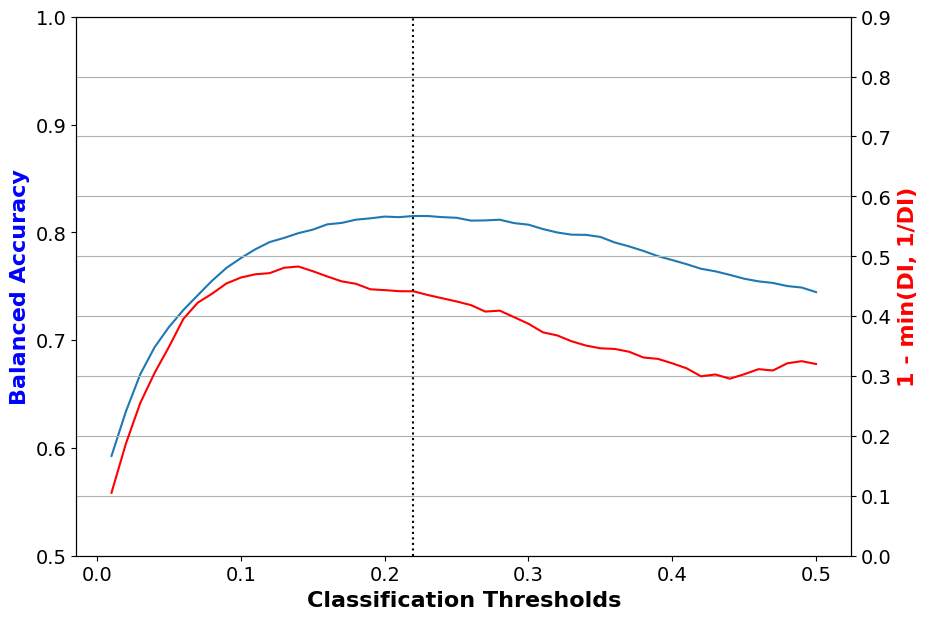

In [51]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

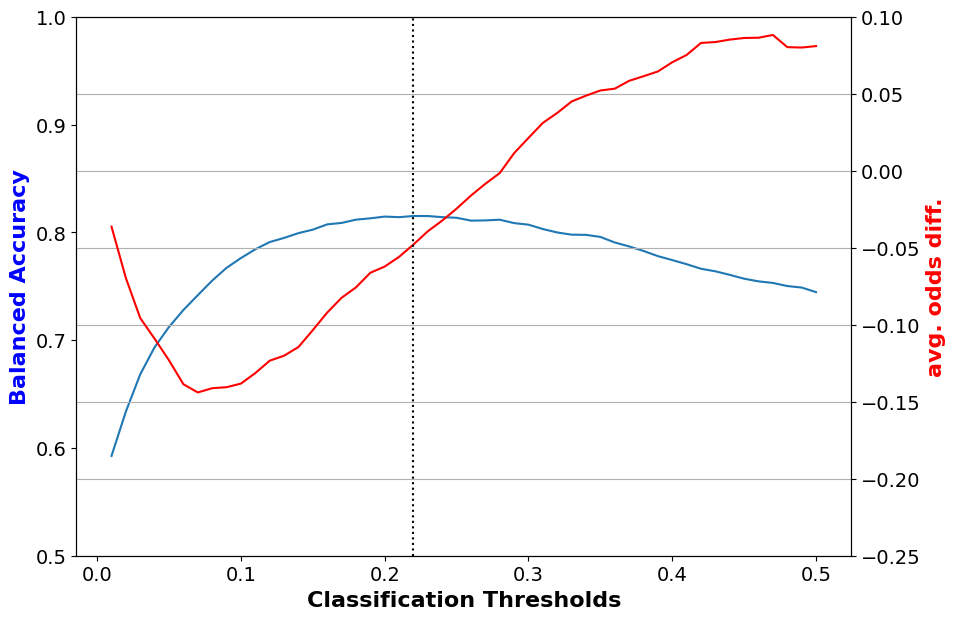

In [52]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [53]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.8151
Corresponding 1-min(DI, 1/DI) value: 0.4415
Corresponding average odds difference value: -0.0479
Corresponding statistical parity difference value: -0.2021
Corresponding equal opportunity difference value: 0.0115
Corresponding Theil index value: 0.0791


##### 4.2.3. Testing RF model after reweighing

In [54]:
rf_transf_metrics = test(dataset=salary_orig_test,
                         model=rf_salary_transf,
                         thresh_arr=[thresh_arr[rf_salary_transf_best_ind]],
                         unprivileged_groups = [{'sex':0}],
                         privileged_groups = [{'sex':1}])

In [55]:
import joblib 
joblib.dump(rf_salary_transf, "./data/rf_salary_transf.pkl")

['./data/rf_salary_transf.pkl']

In [56]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_salary_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.8111
Corresponding 1-min(DI, 1/DI) value: 0.4954
Corresponding average odds difference value: -0.0635
Corresponding statistical parity difference value: -0.2315
Corresponding equal opportunity difference value: -0.0110
Corresponding Theil index value: 0.0807


The model learned from the transformed data is fairer than that learned from the original data. 

However, the random forest model learned from the transformed data is still relatively unfair.

### 5. Explain individual predictions of the rf_salary_tranf model.

ref. Shap README.md documentation: https://github.com/shap/shap/blob/master/README.md

In [57]:
#! pip install shap
import shap

# print shap.__version__
print(shap.__version__)

0.50.0


In [58]:
import joblib 
rf_salary_transf = joblib.load("./data/rf_salary_transf.pkl")

In [59]:
dataset = salary_orig_test.copy()

print(dataset.feature_names)
print(dataset.label_names)

# If you have run the code above, you can use:
df, df_dict = dataset.convert_to_dataframe(de_dummy_code=False)

# Otherwise, you can load df and df_dict (after retrieving the data and putting it in the data folder)
# df = pd.read_parquet("./data/salary_test_df.parquet")
# df_dict = "./data/salary_test_dict.pkl"

print(df.shape)
print(df.columns)

for k, v in df_dict.items():
    print(f"k: {k}")

# Extract the RandomForestClassifier from the AIF360 Pipeline
rf_model = rf_salary_transf.named_steps['randomforestclassifier']

# Alternatively, if you don't know the step name, access by index
# rf_model = pipeline.steps[0][1]


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
['salary']
(6508, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')
k: feature_names
k: label_names
k: protected_attribute_names
k: instance_names
k: instance_weights
k: privileged_protected_attributes
k: unprivileged_protected_attributes


In [60]:
# print(X.shape)
# df_train, df_dict_train = dataset_salary_transf_train.convert_to_dataframe(de_dummy_code=False)
# print(df_train.shape)
# for col in df_train.columns:
#     print(col)

In [61]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)

# Import the TreeExplainer
# As we've trained a random forest model, it is best to use the TreeExplainer, this is optimized for tree-based models.


# Apply the TreeExplainer to the model.


In [62]:
# Drop the column 'salary' from the test dataframe (df).
# 'salary' is the target, it should not be in the feature dataframe.
# Call the feature dataset 'X'
X = 

# print out the columns of X


SyntaxError: invalid syntax (1359524841.py, line 4)

In [ ]:
# Calculate the shap_values for the test set.


In [ ]:
# print the shap_values.

# What attributes does the shap_values object have?
# What do they mean?

# For each observation, there are 2 base values (average prediction by the model).
# What does the first value mean? What does the second value mean?

# visualize the first prediction's explanation using the waterfall plot.
# use as argument for the waterfall plot: shap_values[0,:,1]


In [ ]:
# visualize the first prediction's explanation with a force plot
# print(help(shap.plots.force))
# print(shap_values)
# print the JS visualization code to the notebook
shap.initjs()

# The first parameter should be the expected value for the target class, 1
# The second parameter are all shap values for the first observation (observation with index 0), wrt the target class, 1.
# The thrid parameter is the data for the first observation (I think), i.e. X.iloc[0,:]
shap.force_plot(

In [ ]:
# Visualize many predictions in a force_plot
# To keep the browser happy we only visualize 200 individuals.
print(shap_values.values[0:2,:,1])

shap.force_plot(


[[ 3.66375807e-02  6.41331342e-03 -1.26821405e-03  8.38600878e-03
  -4.34072501e-02 -4.63170073e-02  7.90202113e-03 -7.25856408e-02
   1.14932802e-03 -1.67132622e-03 -3.04389631e-02 -6.61179621e-03
  -3.27877630e-02  5.83679865e-06]
 [ 3.11447713e-02  8.19018364e-03 -8.26800142e-03  9.63961686e-03
  -5.31704032e-02 -2.73028454e-02  2.72987253e-02 -6.51553101e-02
   1.53508878e-03 -3.43138618e-03 -3.00534190e-02 -6.84684508e-03
   7.16337237e-02  1.78509824e-04]]


### Examine the feature importance of the rf_salary_tranf model.

#### shap beswarm plot

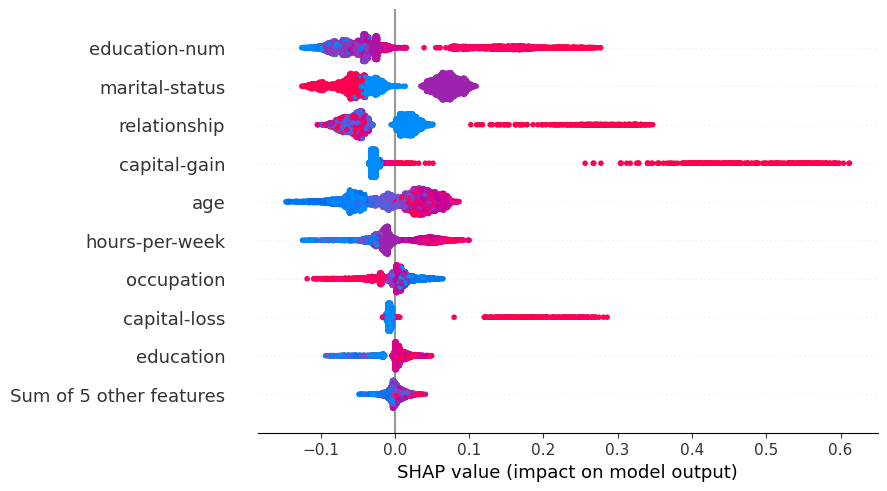

In [ ]:
# summarize the effects of all the features
# import matplotlib.pyplot as plt
# import numpy as np

fig, ax = plt.subplots()
# help(shap.plots.beeswarm)
shap.plots.beeswarm(

#### Shap Summary plot

In [ ]:
# shap.summary_plot(shap_values.values[:,:,1], X,  color_bar=False)

#### Shap dependence plots
o.a. ref. https://shap.github.io/shap/notebooks/plots/dependence_plot.html

In [ ]:
print(X.columns)
print(X.shape)

# Create a shap dependency plot for the features "education-num" and "age".

# We can pass a feature name instead of an index
# shap.dependence_plot(

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
(6508, 14)


In [ ]:
# shap dependence plot for age.
# shap.dependence_plot("age", shap_values.values[:,:,1], X)